# FGSM on mnist

Using device: cuda
Epoch 1, Loss: 0.1673
Epoch 2, Loss: 0.0544
Epoch 3, Loss: 0.0392
Epoch 4, Loss: 0.0316
Epoch 5, Loss: 0.0269
Epoch 6, Loss: 0.0222
Epoch 7, Loss: 0.0199
Epoch 8, Loss: 0.0163
Epoch 9, Loss: 0.0163
Epoch 10, Loss: 0.0143
Accuracy: 0.9930, Precision: 0.9930, Recall: 0.9930, F1 Score: 0.9930


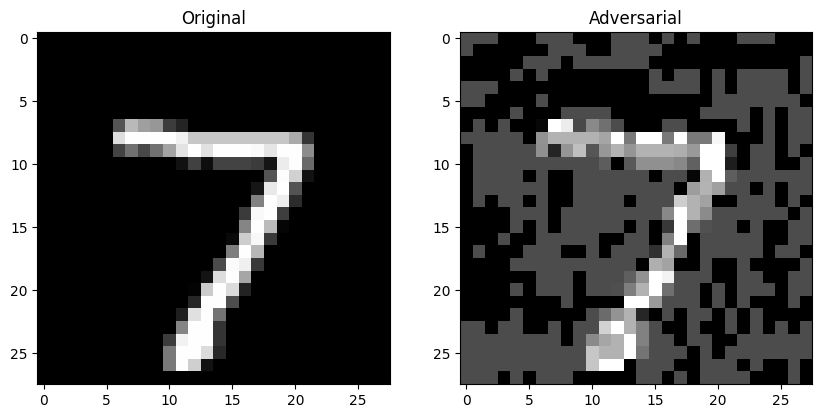

[Adversarial Training with Preprocessing] Epoch 1, Loss: 0.4581
[Adversarial Training with Preprocessing] Epoch 2, Loss: 0.2061
[Adversarial Training with Preprocessing] Epoch 3, Loss: 0.1565
[Adversarial Training with Preprocessing] Epoch 4, Loss: 0.1135
[Adversarial Training with Preprocessing] Epoch 5, Loss: 0.2041
[Adversarial Training with Preprocessing] Epoch 6, Loss: 0.1798
[Adversarial Training with Preprocessing] Epoch 7, Loss: 0.1302
[Adversarial Training with Preprocessing] Epoch 8, Loss: 0.1324
[Adversarial Training with Preprocessing] Epoch 9, Loss: 0.1176
[Adversarial Training with Preprocessing] Epoch 10, Loss: 0.0925
After Adversarial Training with Preprocessing:
Accuracy: 0.8663, Precision: 0.9018, Recall: 0.8663, F1 Score: 0.8517


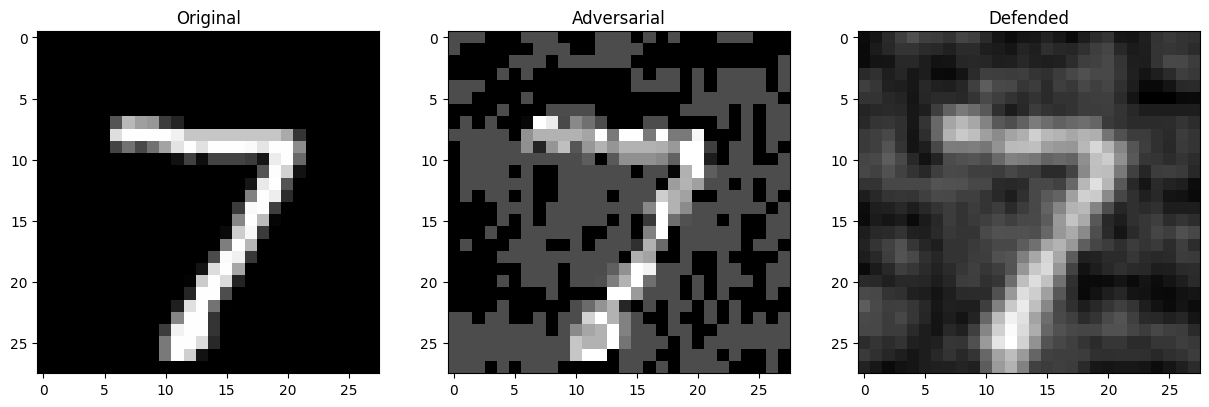

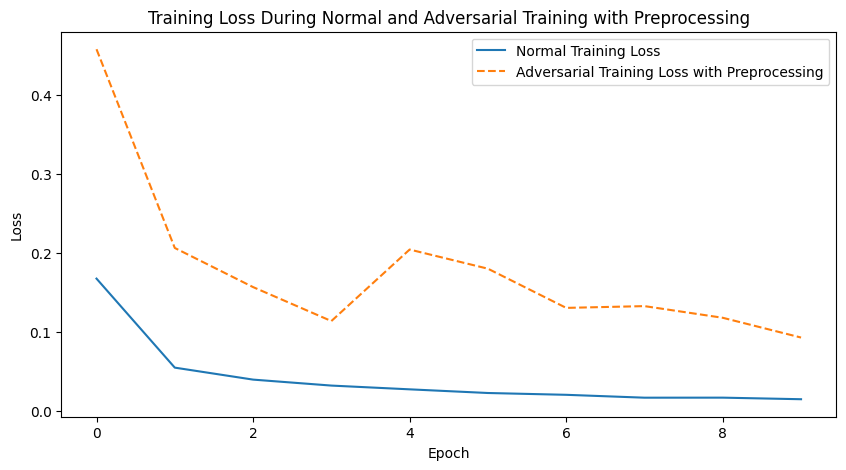

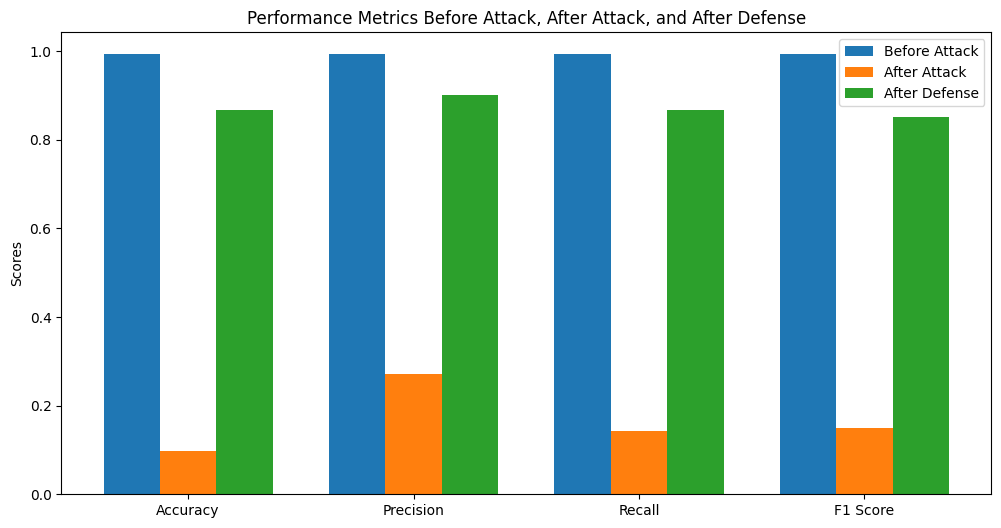

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# ===== 1. تنظیمات اولیه =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Global variable for number of epochs
NUM_EPOCHS = 10

# ===== 2. تعریف مدل =====
class ComplexCNN(nn.Module):
    def __init__(self):
        super(ComplexCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = ComplexCNN().to(device)

# ===== 3. آماده‌سازی داده =====
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ===== 4. تنظیمات آموزش =====
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def train_model(model, loader, epochs=NUM_EPOCHS):
    model.train()
    loss_values = []
    for epoch in range(1, epochs + 1):
        epoch_loss = 0
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(loader)
        loss_values.append(avg_loss)
        print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")
    return loss_values

loss_values = train_model(model, train_loader)

# ===== 5. حمله FGSM =====
def fgsm_attack(model, data, target, epsilon):
    data.requires_grad = True
    output = model(data)
    loss = criterion(output, target)
    model.zero_grad()
    loss.backward()

    perturbed_data = data + epsilon * data.grad.sign()
    perturbed_data = torch.clamp(perturbed_data, 0, 1)
    return perturbed_data.detach()

# ===== 6. ارزیابی =====
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    accuracy = correct / total
    precision = precision_score(all_targets, all_preds, average='weighted')
    recall = recall_score(all_targets, all_preds, average='weighted')
    f1 = f1_score(all_targets, all_preds, average='weighted')
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    return accuracy, precision, recall, f1

# ارزیابی قبل از حمله
accuracy_before_attack, precision_before_attack, recall_before_attack, f1_before_attack = evaluate_model(model, test_loader)

# ===== 7. اعمال حمله =====
epsilon = 0.3
perturbed_samples = []
original_samples = []
accuracy_after_attack, precision_after_attack, recall_after_attack, f1_after_attack = 0, 0, 0, 0

all_targets = []
all_preds_attack = []

for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    perturbed_data = fgsm_attack(model, data, target, epsilon)
    output = model(perturbed_data)
    pred = output.argmax(dim=1, keepdim=True)
    all_preds_attack.extend(pred.cpu().numpy())
    all_targets.extend(target.cpu().numpy())

    if len(perturbed_samples) < 1:  # Capture only the first batch for visualization
        perturbed_samples.append(perturbed_data[0].detach().cpu())
        original_samples.append(data[0].detach().cpu())

accuracy_after_attack = np.mean(np.array(all_preds_attack) == np.array(all_targets))
precision_after_attack = precision_score(all_targets, all_preds_attack, average='weighted')
recall_after_attack = recall_score(all_targets, all_preds_attack, average='weighted')
f1_after_attack = f1_score(all_targets, all_preds_attack, average='weighted')

if not original_samples or not perturbed_samples:
    print("No samples available for visualization. Check the test_loader or attack logic.")
else:
    # ===== 8. نمایش تصاویر =====
    def show_images(original, adversarial, defended=None):
        if defended is not None:
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(original.cpu().squeeze(), cmap="gray")
            axes[0].set_title("Original")
            axes[1].imshow(adversarial.cpu().squeeze(), cmap="gray")
            axes[1].set_title("Adversarial")
            axes[2].imshow(defended.cpu().squeeze(), cmap="gray")
            axes[2].set_title("Defended")
        else:
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].imshow(original.cpu().squeeze(), cmap="gray")
            axes[0].set_title("Original")
            axes[1].imshow(adversarial.cpu().squeeze(), cmap="gray")
            axes[1].set_title("Adversarial")
        plt.show()

    show_images(original_samples[0], perturbed_samples[0])

# ===== 9. تکنیک دفاعی: ترکیب Preprocessing و Adversarial Training =====
def preprocessing_defense(data):
    # Apply Gaussian blur as a preprocessing defense
    from torchvision.transforms import GaussianBlur
    blur = GaussianBlur(kernel_size=3)
    return blur(data)

def adversarial_training_with_preprocessing(model, train_loader, epsilon, epochs=NUM_EPOCHS):
    model.train()
    adv_loss_values = []
    for epoch in range(1, epochs + 1):
        epoch_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            perturbed_data = fgsm_attack(model, data, target, epsilon)
            preprocessed_data = preprocessing_defense(perturbed_data)

            optimizer.zero_grad()
            output = model(preprocessed_data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(train_loader)
        adv_loss_values.append(avg_loss)
        print(f"[Adversarial Training with Preprocessing] Epoch {epoch}, Loss: {avg_loss:.4f}")
    return adv_loss_values

adv_loss_values_with_preprocessing = adversarial_training_with_preprocessing(model, train_loader, epsilon)

# ===== 10. ارزیابی نهایی =====
defended_samples = []
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    perturbed_data = fgsm_attack(model, data, target, epsilon)
    preprocessed_data = preprocessing_defense(perturbed_data)
    defended_output = model(preprocessed_data)
    defended_samples.append(preprocessed_data[0].detach().cpu())
    break

print("After Adversarial Training with Preprocessing:")
accuracy_after_training, precision_after_training, recall_after_training, f1_after_training = evaluate_model(model, test_loader)

# نمایش تصاویر با دفاع
if defended_samples:
    show_images(original_samples[0], perturbed_samples[0], defended_samples[0])

# ===== 11. نمایش نمودارها =====
def plot_metrics(normal_loss, adv_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(normal_loss, label="Normal Training Loss")
    plt.plot(adv_loss, label="Adversarial Training Loss with Preprocessing", linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss During Normal and Adversarial Training with Preprocessing")
    plt.legend()
    plt.show()

def plot_accuracy_metrics(before_metrics, after_attack_metrics, after_defense_metrics):
    labels = ["Accuracy", "Precision", "Recall", "F1 Score"]
    before_values = list(before_metrics)
    attack_values = list(after_attack_metrics)
    defense_values = list(after_defense_metrics)

    x = np.arange(len(labels))
    width = 0.25

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width, before_values, width, label="Before Attack")
    ax.bar(x, attack_values, width, label="After Attack")
    ax.bar(x + width, defense_values, width, label="After Defense")

    ax.set_ylabel("Scores")
    ax.set_title("Performance Metrics Before Attack, After Attack, and After Defense")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.show()

plot_metrics(loss_values, adv_loss_values_with_preprocessing)
plot_accuracy_metrics((accuracy_before_attack, precision_before_attack, recall_before_attack, f1_before_attack),
                      (accuracy_after_attack, precision_after_attack, recall_after_attack, f1_after_attack),
                      (accuracy_after_training, precision_after_training, recall_after_training, f1_after_training))
